Hello Kagglers! I am back to Kaggle after a long time and I thought that it would be good to start with a notebook. 

### Disclaimer
This is a copy of [raddar's](https://www.kaggle.com/raddar) work. The original notebook is [here](https://www.kaggle.com/raddar/bone-drr-unet/notebook). In this notebook, I will show you the nice things that you will get to use in new Tensorflow version. Also, I refactored the code a lot, so I might have missed something(though dobutful!).

In [1]:
# Let's install tensorflow 2.2 first
!pip install tensorflow==2.2rc2

     |████████████████████████████████| 516.1 MB 19 kB/s 
     |████████████████████████████████| 3.0 MB 61.3 MB/s 
     |████████████████████████████████| 454 kB 45.9 MB/s 
     |████████████████████████████████| 777 kB 45.7 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.1.0
    Uninstalling tensorflow-2.1.0:
      Successfully uninstalled tensorflow-2.1.0


# UNet to predict bone layer on chest X-rays

We are going to use **synthetically** generated X-rays in the form of CT DRR to train UNet model with perception loss. The [dataset](https://www.kaggle.com/raddar/digitally-reconstructed-radiographs-drr-bones) will be used in further experiments.

Digitally Reconstructed Radiograph (DRR) is a novel approach to generate synthetic chest X-rays (CXR) from real CT scan data. Although real data was used, I am using term **synthetic**, as the DRR images were generated in a process described with parametric model (more on that: https://arxiv.org/pdf/2003.10839.pdf). The parameters were selected to pass the human eye test - if the generated image resembles appearance of a real chest X-ray. Moreover, the synthetic images would be considered too blurry and of very low quality compared to X-rays taken with standard X-ray devices.

Although DRR has obvious drawbacks, it can make use of most of the good stuff coming from CT scans, like bones, soft tissue, organs, etc. can be easily separated.

This notebook was an interesting weekend project for me to explore, if chest CT scan data can yield a model suitable for chest X-ray modality. It could also solve some tasks such as segmenting the ribs and other bones - which is a very tedious task to hand label on chest X-rays.

### Import all the libraries we need

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import vgg19

from albumentations import (
                        PadIfNeeded,
                        HorizontalFlip,
                        VerticalFlip,    
                        CenterCrop,    
                        Crop,
                        Compose,
                        Transpose,
                        RandomRotate90,
                        Rotate,
                        RandomSizedCrop,
                        OneOf,
                        CLAHE,
                        RandomBrightnessContrast,    
                        RandomGamma    
                    )

# always set the seed
seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)
sns.set()
%matplotlib inline

### Dataset prepration
If possible, I always like to store the information in a pandas dataframe. Makes life much easier!

In [3]:
# path to the original files
files_path = Path("../input/digitally-reconstructed-radiographs-drr-bones")

# get all the file names as a list of strings
files = list(map(str, list(files_path.glob("**/*.png"))))
print("Total number of files found: ", len(files))


# store the above info in a pandas dataframe
bone_drr = pd.DataFrame([(x, x.replace('.png','_mask.png')) for x in files if not x.endswith('_mask.png')])
bone_drr.columns = ['image','bones']
print(f'Total instances: {bone_drr.shape[0]}')
bone_drr.head()

Total number of files found:  386
Total instances: 193


,image,bones
0,../input/digitally-reconstructed-radiographs-d...,../input/digitally-reconstructed-radiographs-d...
1,../input/digitally-reconstructed-radiographs-d...,../input/digitally-reconstructed-radiographs-d...
2,../input/digitally-reconstructed-radiographs-d...,../input/digitally-reconstructed-radiographs-d...
3,../input/digitally-reconstructed-radiographs-d...,../input/digitally-reconstructed-radiographs-d...
4,../input/digitally-reconstructed-radiographs-d...,../input/digitally-reconstructed-radiographs-d...


### Sanity check
Let's load some images and the corresponding bone images

In [4]:
def plot_random_images(nb_images, df, idx=None, figsize=(15,8)):
    """Plots random images from the data
    Args:
        nb_images: Number of images to plot
        df: dataframe object
        idx: list of the indices to plot
        figsize: size of the plot
    """
    
    if idx is not None:
        idx = idx
        if nb_images != len(idx):
            raise ValueError("""Number of indices and the 
            number of images to plot should be same""")
    else:
        idx = np.random.choice(len(df), size=nb_images)
        
    ncols = 2
    nrows = nb_images
        
    f, ax = plt.subplots(nrows, ncols, figsize=figsize)
    
    for i, index in enumerate(idx):
        img = cv2.imread(df['image'][index], 0)
        bone = cv2.imread(df['bones'][index], 0)
        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(bone, cmap='gray')
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()

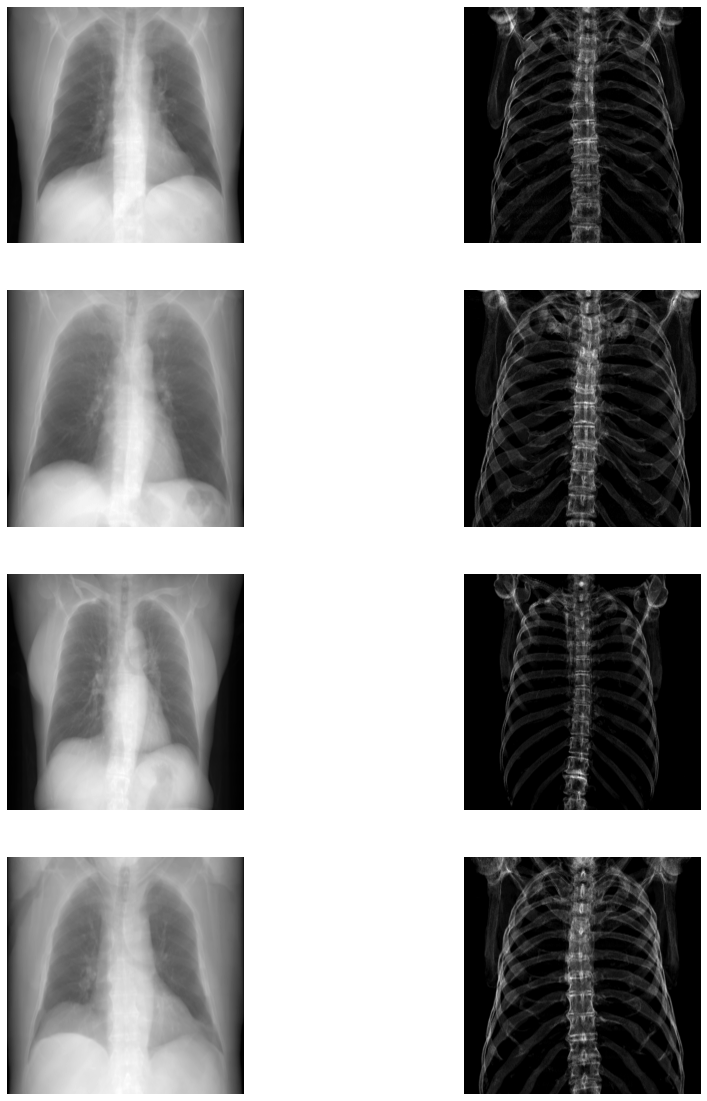

In [5]:
plot_random_images(nb_images=4, df=bone_drr, figsize=(15, 20))

The chest X-ray image looks too blurry to be considered a standard X-ray. Other than that, it is a nice looking image with no artifacts. As for bone mask layer - it appears only bone tissue is visualized - this is what we want to predict on a regular chest X-ray!

So, we have almost 200 images to work with. It seems like not much, but the images are heavily standardized, thus it may be possible for a network to learn something here. Fingers crossed!

### Split dataset into train and validation sets

In [6]:
IMG_SHAPE = (512, 512, 3)
SPLIT_IDX = 160

# Shuffle rows in dataframe
bone_drr = bone_drr.sample(frac=1, random_state=seed)
df_train = bone_drr[:SPLIT_IDX].reset_index(drop=True)
df_val = bone_drr[SPLIT_IDX:].reset_index(drop=True)

The dataset is small. It's much better to store the images into numpy arrays and work with them afterwards.

**Note**: raddar normalized the image and masks here only. I won't do it here because while doing augmentation, it is better to work with raw pixel integer values.

In [7]:
def load_data_as_numpy_array(df, im_shape):
    X, y = [], []
    for i in range(len(df)):
        img = cv2.imread(df['image'][i], 0)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, im_shape[:2])
        
        mask = cv2.imread(df['bones'][i])
        mask = cv2.resize(mask, im_shape[:2])
        
        X.append(img)
        y.append(mask)
    
    X = np.array(X)
    y = np.array(y)
    return X, y

In [8]:
# Load training and validation data
X_train, y_train = load_data_as_numpy_array(df_train, IMG_SHAPE)
X_val, y_val = load_data_as_numpy_array(df_val, IMG_SHAPE)

### Augmentation pipeline
We want to do augmentation on the fly. I will be using the [albumentations](https://github.com/albumentations-team/albumentations) library for it as it's **the best** library for doing augmentation.

**Note:** raddar used the customized `ImageDataGenerator` but IMO this is a much simpler and better way to do it.

In [9]:
class DataGenerator(Sequence):
    """Performs augmentation using albumentations"""
    def __init__(self, 
                 data, 
                 labels,
                 img_dim=IMG_SHAPE, 
                 batch_size=32,  
                 shuffle=True,
                 augment=True,
                ):
        """
        Args:
            data: numpy array containing images
            labels: numpy array containing corresponding masks
            img_dim: fixed image shape that is to be used
            batch_size: batch size for one step
            shuffle: (bool) whether to shuffle the data or not
            augment: (bool) whether to augment the data or not
        
        Returns:
            A batch of images and corresponding masks
        """
        
        self.data = data
        self.labels = labels
        self.img_dim = img_dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.data))
        self.augmentations()
        self.on_epoch_end()
        
        
    def augmentations(self):
        self.aug = OneOf([VerticalFlip(p=0.2),
                        HorizontalFlip(p=1.0),
                        RandomBrightnessContrast(p=0.5),
                        Rotate(p=1.0, limit=20, border_mode=0)])
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def augment_data(self, img, label):
        augmenetd = self.aug(image=img, mask=label)
        return augmenetd['image'], augmenetd['mask']


    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    
    def __getitem__(self, idx):
        curr_batch = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        # print(curr_batch)
        batch_len = len(curr_batch)  
        X = np.zeros((batch_len, *self.img_dim), dtype=np.float32)
        y = np.zeros((batch_len, *self.img_dim), dtype=np.float32)
        
        for i, index in enumerate(curr_batch):
            img = self.data[index]
            label = self.labels[index]
            if self.augment:
                img, label = self.augment_data(img, label)
            img = img.astype(np.float32)
            img -= img.mean()
            img /= img.std()
            label = label.astype(np.float32) / 127.5 -1.
            
            X[i], y[i] = img, label
        return X, y

### Model definition
**UNet + dilated convolutions + perception loss**: The analyzed paper (https://arxiv.org/pdf/2003.10839.pdf) used standard UNet model with dilated convolutions. Let's take one, shamelessly taken from https://github.com/GlastonburyC/Dilated-U-net/blob/master/dilatedUnet.py.

**Note:** Here are the biggest changes in the code. I refactored it to make it less cluttered. Apart from refactoring, the model is same.

In [10]:
def conv_block(inputs,
               filters, 
               kernel_size, 
               dilation_rate=1, 
               padding="same", 
               activation="relu",
               kernel_initializer="he_normal"):
    
    x = layers.Conv2D(filters,
                      kernel_size=kernel_size,
                      dilation_rate=dilation_rate,
                      kernel_initializer=kernel_initializer,
                      padding=padding,
                      activation=activation
                     )(inputs)
    return x

def pool_block(inputs, pool="max", pool_size=((2,2)), strides=(2,2)):
    return layers.MaxPooling2D(strides=strides, pool_size=pool_size)(inputs)

In [11]:
def dilated_unet(im_shape, addition=1, dilate=1, dilate_rate=1):
    x = inputs = layers.Input(im_shape)
    
    down1 = conv_block(x, 44, 3)
    down1 = conv_block(x, 44, 3, dilation_rate=dilate_rate)
    down1pool = pool_block(down1)
    
    down2 = conv_block(down1pool, 88, 3)
    down2 = conv_block(down1pool, 88, 3, dilation_rate=dilate_rate)
    down2pool = pool_block(down2)
    
    down3 = conv_block(down2pool, 176, 3)
    down3 = conv_block(down3, 176, 3, dilation_rate=dilate_rate)
    down3pool = pool_block(down3)
    
    if dilate == 1:
        dilate1 = conv_block(down3pool, 176, 3, dilation_rate=1)
        dilate2 = conv_block(dilate1, 176, 3, dilation_rate=2)
        
        if addition == 1:
            dilate_all_added = layers.add([dilate1, dilate2])
            up3 = layers.UpSampling2D((2, 2))(dilate_all_added)
        else:
            up3 = layers.UpSampling2D((2, 2))(dilate2)
            
    up3 = conv_block(up3, 88, 3)
    up3 = layers.concatenate([down3, up3])
    up3 = conv_block(up3, 88, 3)
    up3 = conv_block(up3, 88, 3)
    
    up2 = layers.UpSampling2D((2, 2))(up3)
    up2 = conv_block(up2, 44, 3)
    up2 = layers.concatenate([down2, up2])
    up2 = conv_block(up2, 44, 3)
    up2 = conv_block(up2, 44, 3)
    
    up1 = layers.UpSampling2D((2, 2))(up2)
    up1 = conv_block(up1, 22, 3)
    up1 = layers.concatenate([down1, up1])
    up1 = conv_block(up1, 22, 3)
    up1 = conv_block(up1, 22, 3)
    
    out = layers.Conv2D(1, 1, activation="tanh")(up1)
    model = models.Model(inputs=inputs, outputs=out)
    return model

In [12]:
dunet = dilated_unet(IMG_SHAPE)
dunet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 44) 1232        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 44) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 88) 34936       max_pooling2d[0][0]              
______________________________________________________________________________________________

### Loss function

Before start training something, let's look at the proposed loss function to use during training.
As the training sample is quite small, standard loss functions like MSE or RMSE on pixel level not necessarily translates to good looking bone mask predictions - this was also observed in the paper. Perception loss was introduced - which is a very interesting concept.

The idea of perception loss is to compare feature maps of proxy model, providing original input (bone mask) and predicted output (predicted bone mask by UNet) - and calculating difference between them. The smaller overall mean difference - the more conceptually similar original and predicted images are! 

Moreover, perceptual loss helps us somewhat deal with data being synthetic, as model focuses less on overfitting to the blurry synthetic data we have. This is important for our task - transfer the model to real X-rays.

Let's use good old VGG19 model and take one of its layers as a perception vector.

In [13]:
vgg = vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(512, 512, 3))
loss_model = models.Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)
loss_model.trainable = False
loss_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
____________________________________________________________

In [14]:
def perceptual_loss_vgg19(y_true, y_pred):
    y_pred = tf.image.grayscale_to_rgb(y_pred, name=None)
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

### Training
Here are the biggest changes. Although in this case, this isn't necessary, this is to show that how can you override the `train` and `test` steps. Why though? Two reasons:

1. When writing custom training loops, you often lose some good things like callbacks, checkpointing, etc and you have to write these as well with the custom logic. 
2. If you override train and test steps, all you have to change the code at two place only and rest everything would work as with a native keras model. Then, you won't have to write functionlities like custom callbacks and all 

In [15]:
class BoneUNet(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        
    def compile(self, base_model_opt, loss_fn):
        super().compile()
        self.base_model_optimizer = base_model_opt
        self.loss_fn = loss_fn
        
    def train_step(self, inputs):
        images, labels =  inputs
        
        with tf.GradientTape() as tape:
            preds = self.base_model(images, training=True)
            loss = self.loss_fn(labels, preds)
        
        grads = tape.gradient(loss, self.base_model.trainable_weights)
        self.base_model_optimizer.apply_gradients(
                    zip(grads, self.base_model.trainable_weights)) 
        
        return {'loss':loss}
    
    def call(self, images):
        preds = self.base_model(images, training=False)    
        return preds
        
    def test_step(self, inputs):
        images, labels = inputs
        preds = self.call(images)
        loss = self.loss_fn(labels, preds)
        return {'loss': loss}

In [16]:
bone_model = BoneUNet(base_model=dunet)
bone_model.compile(optimizers.Adam(), loss_fn=perceptual_loss_vgg19)

batch_size = 8
epochs = 100
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

nb_train_steps = int(np.ceil(len(X_train) / batch_size))
nb_valid_steps = int(np.ceil(len(X_val)) / batch_size)

train_data_gen = DataGenerator(data=X_train,
                               labels=y_train,
                               batch_size=batch_size,
                               shuffle=True,
                               augment=False)

valid_data_gen = DataGenerator(data=X_val,
                              labels=y_val,
                              batch_size=batch_size,
                              shuffle=False,
                              augment=False)

In [17]:
bone_model.fit(train_data_gen,
                validation_data=valid_data_gen,
                epochs=epochs,
                steps_per_epoch=nb_train_steps,
                validation_steps=nb_valid_steps,
                callbacks=[es])

Epoch 1/100
20/20 [==============================] - 13s 626ms/step - loss: 20.8642 - val_loss: 18.8612
Epoch 2/100
20/20 [==============================] - 12s 592ms/step - loss: 17.1603 - val_loss: 17.7601
Epoch 3/100
20/20 [==============================] - 12s 591ms/step - loss: 15.8172 - val_loss: 16.1215
Epoch 4/100
20/20 [==============================] - 12s 596ms/step - loss: 14.7851 - val_loss: 14.9261
Epoch 5/100
20/20 [==============================] - 12s 592ms/step - loss: 14.3259 - val_loss: 14.5807
Epoch 6/100
20/20 [==============================] - 12s 591ms/step - loss: 13.7879 - val_loss: 14.3115
Epoch 7/100
20/20 [==============================] - 12s 592ms/step - loss: 13.3241 - val_loss: 13.5969
Epoch 8/100
20/20 [==============================] - 12s 590ms/step - loss: 13.0846 - val_loss: 13.3988
Epoch 9/100
20/20 [==============================] - 12s 593ms/step - loss: 12.4952 - val_loss: 12.8329
Epoch 10/100
20/20 [==============================] - 12s 590ms/

### Sample predictions

In [18]:
def plot_prediction(filepath, figsize=(16, 8)):
    orig_img = cv2.imread(filepath, 0)
    img = orig_img.copy()
    
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (512, 512))
    
    img = img.astype(np.float32)
    img -= img.mean()
    img /= img.std()
    
    pred = bone_model.predict(np.expand_dims(np.array(img), 0))[0, :, :, 0]
    pred = ((pred + 1)*127.5).astype(np.uint8)
    pred = cv2.resize(pred, (img.shape[1], img.shape[0]))
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].imshow(orig_img, 'gray')
    axes[1].imshow(pred, 'gray')
    plt.show()

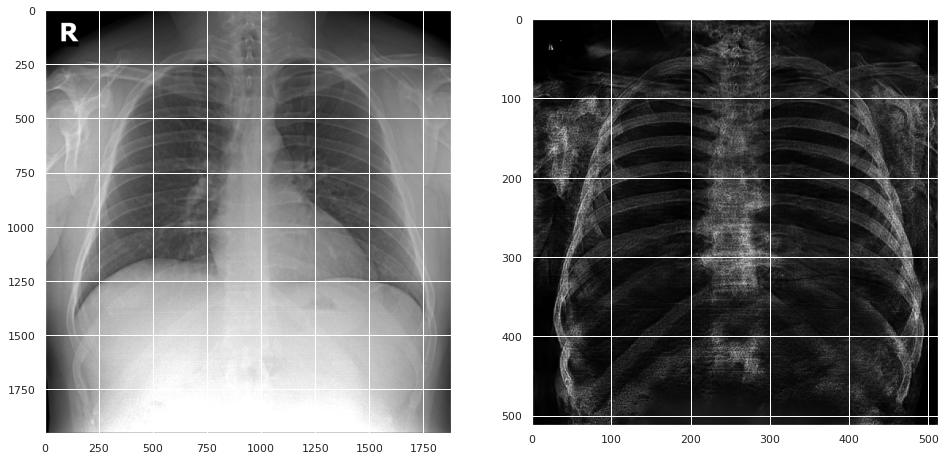

In [19]:
sample_img_path = '../input/padchest-chest-xrays-sample/sample/216840111366964012819207061112010316094555679_04-017-068.png'
plot_prediction(sample_img_path)

There is a lot more that can be done in this model to improve the quality of preedictions. I will leave it here as I just wanted to showcase the other things, especially the `train` and `test` steps. Feedback is always welcome!